In [28]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import plotly.express as px
import warnings

layout = {
    'showlegend': True,
    'margin': {'b':10, 'l':20, 'r':50, 't':50},
    'font': {'size': 19},
    'xaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'yaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'template': 'plotly_white',
}

px.defaults.color_discrete_sequence = px.colors.qualitative.T10

# Import Quoilin dataset
Data available at: https://github.com/squoilin/Self-Consumption/releases Synthetic.Household.Profiles.h5

In [29]:
df = pd.read_pickle("../2_chapter/fr_quoilin_data_valence.pickle")
df.columns

Index(['2000900', '2000901', '2000903', '2000904', '2000905', '2000906',
       '2000907', '2000908', '2000909', '2000910',
       ...
       '2001188', '2001189', '2001190', '2001192', '2001193', '2001194',
       '2001195', '2001197', '2001199', 'pv_1kw'],
      dtype='object', length=174)

# Set study on 20 households

In [30]:
nb_houses = 20

In [31]:
house_ids=[
    "2000989",
    "2001197",
    "2000914",
    "2001123",
    "2000964",
    "2001189",
    "2001111",
    "2001179",
    "2000909",
    "2000918",
    "2000994",
    "2001107",
    "2000913",
    "2001139",
    "2000960",
    "2001149",
    "2001165",
    "2000954",
    "2001114",
    "2000926",
]
df = df[house_ids + ["pv_1kw"]]
print(f"Average consumption is {round((df[house_ids].sum() * 15 / 60).mean() / 1000, 2)} MWh")

Average consumption is 5.56 MWh


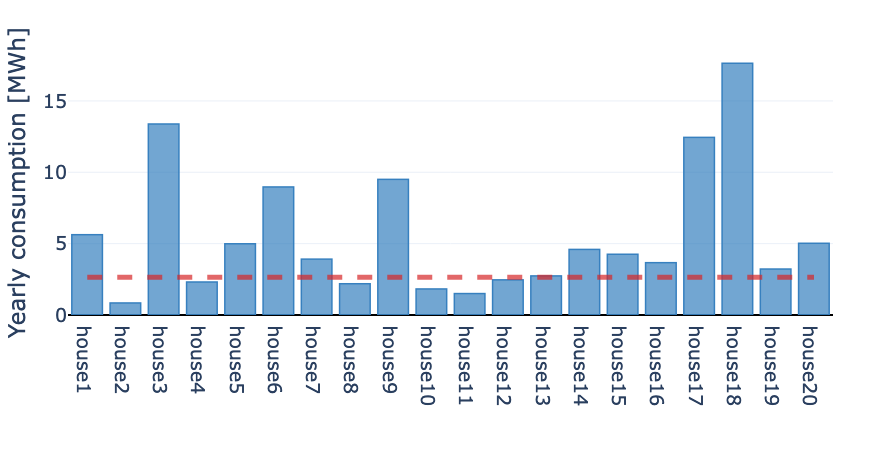

In [32]:
graph = df[[col for col in df.columns if "pv_1kw" not in col]].copy()
graph.columns = ["house" + str(n) for n in range(1, len(graph.columns) + 1)]
fig = px.bar(graph.sum() * 15 / 60 / 1000)
fig.data[0].update(
    {'marker': {'color': 'rgba(55, 128, 191, 0.7)',
                'line': {'width': 1.5,
                'color': 'rgba(55, 128, 191, 1.0)'}}})

# 'Reference for 100m2, 4 people, no elec. heating'
fig.add_shape(
  type='line',
  y0=2650/1000, y1=2650/1000, x0="house1", x1="house20",
  line={'dash': 'dash', 'width': 5,
        'color': 'rgba(214, 39, 40, 0.7)'})

fig.update_layout(
    layout,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Yearly consumption [MWh]")
fig.show()

In [33]:
_individuals = df.copy()
df["community_kW"] = df[house_ids].sum(axis=1)
df.drop(house_ids, axis=1, inplace=True)

In [34]:
individuals = _individuals.copy()

training = timedelta(days=31) - timedelta(days=1)
start = datetime(2019, 5, 30, 0, 0, 0)
end = start + timedelta(days=2)
pv_size = 3

individuals = individuals.loc[start-training:end, :].copy()
for col in individuals.columns:
    individuals[col] -= pv_size * individuals["pv_1kw"]
individuals.drop(columns=["pv_1kw"], inplace=True)

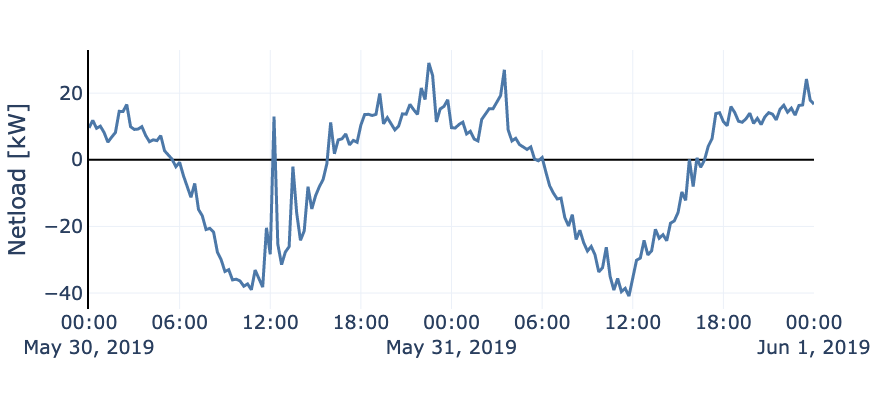

In [35]:
graph = individuals.loc[start:end, :].sum(axis=1).copy()

fig = px.line(graph)
fig.data[0].update(line_width=3)
fig.update_layout(
    layout,
    height=400,
    width=800,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Netload [kW]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show()

# Forecast at different freq (test 1 house)

In [36]:
import os
import pandas as pd
import numpy as np
from prophet import Prophet


class GAM():
    """Generalized Additive Model.
    """

    def __init__(self, output, regressors=None, 
                 daily_seasonality="auto",
                 seasonality_prior_scale=10.0):
        self._output = output
        self._model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality="auto",
            daily_seasonality=daily_seasonality,
            seasonality_mode="additive",
            interval_width=0.95,
            changepoint_prior_scale=0.05,
            seasonality_prior_scale=seasonality_prior_scale,
            uncertainty_samples=False,
        )
        if regressors is None:
            regressors = list()
        for reg in regressors:
            self._model.add_regressor(name=reg["name"], prior_scale=reg["prior_scale"])
        self.raw = pd.DataFrame()

    def fit(self, df):
        with suppress_stdout_stderr():
            self._model.fit(self._specific_formatting(df))

    def predict(self, df):
        forecast = self._model.predict(self._specific_formatting(df))
        self.raw = pd.concat([self.raw, forecast])
        forecast.set_index("ds", inplace=True, drop=True)
        forecast.drop(columns=forecast.columns.difference(["yhat"]), inplace=True)
        forecast.rename(columns={"yhat": self._output}, inplace=True)
        return forecast

    def _specific_formatting(self, df):
        df = df.copy()
        df["ds"] = df.index.tz_localize(None)
        df.rename(columns={self._output: "y"}, inplace=True)
        df.reset_index(inplace=True, drop=True)
        return df


class suppress_stdout_stderr(object):
    """
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    """

    def __init__(self):
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        for fd in self.null_fds + self.save_fds:
            os.close(fd)

def get_gof(ref, pred, ref_col, pred_col):
    """
    gof = (1 - NRMSE) * 100
    """
    pred = pred.loc[:, [pred_col]].copy()
    pred.index = pred.index.tz_localize("UTC")
    pred.columns = ["prediction"]

    ref = df.loc[pred.index[0]:pred.index[-1], [ref_col]].copy()
    ref.columns = ["target"]

    nrmse = (np.linalg.norm(ref["target"].values - pred["prediction"].values, 2) 
           / np.linalg.norm(ref["target"].values - ref["target"].mean(), 2))
    return 100.0 * (1.0 - np.clip(nrmse, a_min=0.0, a_max=1.0))

def lag_values(df, nb_lag, output_col):
    tmp = df.copy()
    for shift in nb_lag:
        tmp[f"t-{shift}"] = tmp[output_col].shift(shift)
    return tmp

from tqdm.notebook import tqdm

def predict_n_periods_with_autoreg(df, start_training, end_training, horizon,
                                   deltat, end_complete_pred, freq, output_col,
                                   regressors, nb_lag):
    """
    Train a GAM and predict for horizon T
    Shift prediction start and predict over T again.
    
    results : [pd.DataFrame] One frame per prediction.
    """
    
    inputs = [reg["name"] for reg in regressors]
    results = []
    model = GAM(output_col, regressors, daily_seasonality="auto", seasonality_prior_scale=1.0)
    
    tmp = lag_values(df.loc[start_training-timedelta(days=1):end_training], nb_lag, output_col)
    model.fit(tmp.loc[start_training:end_training])
    
    # Number of forecast where we have access to actual data
    forecast_freq = pd.date_range(end_training + deltat, end_complete_pred, freq=freq)
    for start_prediction in tqdm(forecast_freq, desc="# Forecast: "):
        tmp_results = []
        end_prediction = start_prediction + horizon
        
        # Get lagged values and NaN to blank future info
        tmp = lag_values(df.loc[start_prediction-timedelta(days=1):end_prediction], nb_lag, output_col)
        tmp = tmp.loc[start_prediction:end_prediction]
        for n in nb_lag:
            tmp.loc[:, f"t-{n}"] = tmp[f"t-{n}"].iloc[0:n].tolist() + ([np.nan] * (len(tmp) - n))
        
        horizon_spam = pd.date_range(start_prediction, end_prediction, freq="15T")
        for step_i, step in enumerate(horizon_spam):
            # Fill up NaN of lagged values with previous results
            for n in nb_lag:
                if pd.isna(tmp.loc[step, f"t-{n}"]):
                    tmp.loc[step, f"t-{n}"] = tmp_results[step_i-n]
            
            res = model.predict(tmp.loc[step:step, inputs])
            tmp_results.append(res.at[step, output_col])
            
        results.append(pd.DataFrame(index=horizon_spam, data={output_col: tmp_results}))
    return results, model

In [53]:
deltat = timedelta(minutes=15)
start_training = start - training + timedelta(days=1)
end_training = start - deltat

horizon = timedelta(days=1)
end_complete_pred = start + horizon
freq = f"{int(1*60)}T"

print(f"Start {end_training + deltat} until {end_complete_pred}")

Start 2019-05-30 00:00:00 until 2019-05-31 00:00:00


In [ ]:
house_id = "2000989"

regressors = [{"name": "pv_1kw", "prior_scale": 10.0}]
nb_lag = list(range(1, 13))
for n in nb_lag:
    regressors.append({"name": f"t-{n}", "prior_scale": 10.0})

data = individuals[[house_id]].copy()
data["pv_1kw"] = df.loc[data.index[0]:data.index[-1], "pv_1kw"]

####
print(f"Training start {start_training.date()} until {end_training}")
print(f"Prediction start {end_training + deltat} until {end_complete_pred}")
####
results, _ = predict_n_periods_with_autoreg(
    data, 
    start_training, 
    end_training, 
    horizon,
    deltat, 
    end_complete_pred, 
    freq, 
    house_id,
    regressors=regressors, 
    nb_lag=nb_lag
)

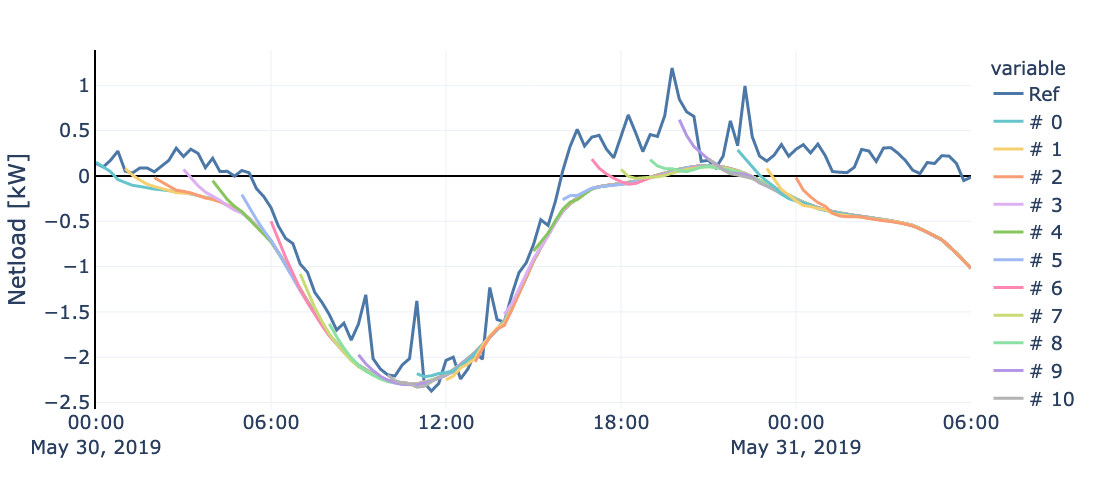

In [63]:
graph = individuals.loc[start:end-timedelta(hours=18), [house_id]].copy()
graph.columns = ["Ref"]

fig = px.line(graph)
fig.data[0].update(line_width=3)

colors = 3 * px.colors.qualitative.Pastel
for i, res in enumerate(results):
    res.columns = [f"# {i}"]
    trace = px.line(res.loc[start:end-timedelta(hours=18), :]).data[0]
    fig.add_trace(trace)
    fig.data[-1].update(
        line_width=3,
        line_color=colors[i], 
        opacity=1)

fig.update_layout(
    layout,
    height=500,
    width=1100,
    showlegend=True,
    xaxis_title="",
    yaxis_title="Netload [kW]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show()

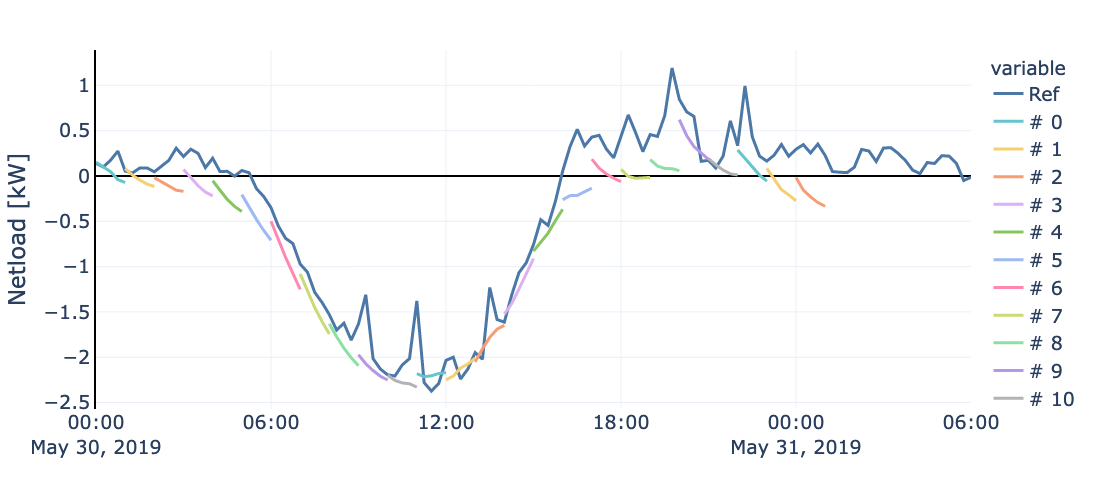

In [64]:
graph = individuals.loc[start:end-timedelta(hours=18), [house_id]].copy()
graph.columns = ["Ref"]

fig = px.line(graph)
fig.data[0].update(line_width=3)

colors = 3 * px.colors.qualitative.Pastel
for i, res in enumerate(results):
    res.columns = [f"# {i}"]
    trace = px.line(res.loc[start:start+(i+1)*timedelta(hours=1), :]).data[0]
    fig.add_trace(trace)
    fig.data[-1].update(
        line_width=3,
        line_color=colors[i], 
        opacity=1)

fig.update_layout(
    layout,
    height=500,
    width=1100,
    showlegend=True,
    xaxis_title="",
    yaxis_title="Netload [kW]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show()

# Forecast at different freq — 5houses

In [65]:
deltat = timedelta(minutes=15)
start_training = start - training + timedelta(days=1)
end_training = start - deltat

horizon = timedelta(days=1)
end_complete_pred = start + horizon
freq = f"{int(1*60)}T"

print(f"Start {end_training + deltat} until {end_complete_pred}")

Start 2019-05-30 00:00:00 until 2019-05-31 00:00:00


In [66]:
house_forecasts = {}

for house_id in house_ids[0:5]:
    regressors = [{"name": "pv_1kw", "prior_scale": 10.0}]
    nb_lag = list(range(1, 13))
    for n in nb_lag:
        regressors.append({"name": f"t-{n}", "prior_scale": 10.0})

    data = individuals[[house_id]].copy()
    data["pv_1kw"] = df.loc[data.index[0]:data.index[-1], "pv_1kw"]

    ####
    print(f"Training start {start_training.date()} until {end_training}")
    print(f"Prediction start {end_training + deltat} until {end_complete_pred}")
    ####
    results, _ = predict_n_periods_with_autoreg(
        data, 
        start_training, 
        end_training, 
        horizon,
        deltat, 
        end_complete_pred, 
        freq, 
        house_id,
        regressors=regressors, 
        nb_lag=nb_lag
    )
    house_forecasts[house_id] = results

Training start 2019-05-01 until 2019-05-29 23:45:00
Prediction start 2019-05-30 00:00:00 until 2019-05-31 00:00:00


# Forecast:   0%|          | 0/25 [00:00<?, ?it/s]

Training start 2019-05-01 until 2019-05-29 23:45:00
Prediction start 2019-05-30 00:00:00 until 2019-05-31 00:00:00


# Forecast:   0%|          | 0/25 [00:00<?, ?it/s]

Training start 2019-05-01 until 2019-05-29 23:45:00
Prediction start 2019-05-30 00:00:00 until 2019-05-31 00:00:00


# Forecast:   0%|          | 0/25 [00:00<?, ?it/s]

Training start 2019-05-01 until 2019-05-29 23:45:00
Prediction start 2019-05-30 00:00:00 until 2019-05-31 00:00:00


# Forecast:   0%|          | 0/25 [00:00<?, ?it/s]

Training start 2019-05-01 until 2019-05-29 23:45:00
Prediction start 2019-05-30 00:00:00 until 2019-05-31 00:00:00


# Forecast:   0%|          | 0/25 [00:00<?, ?it/s]

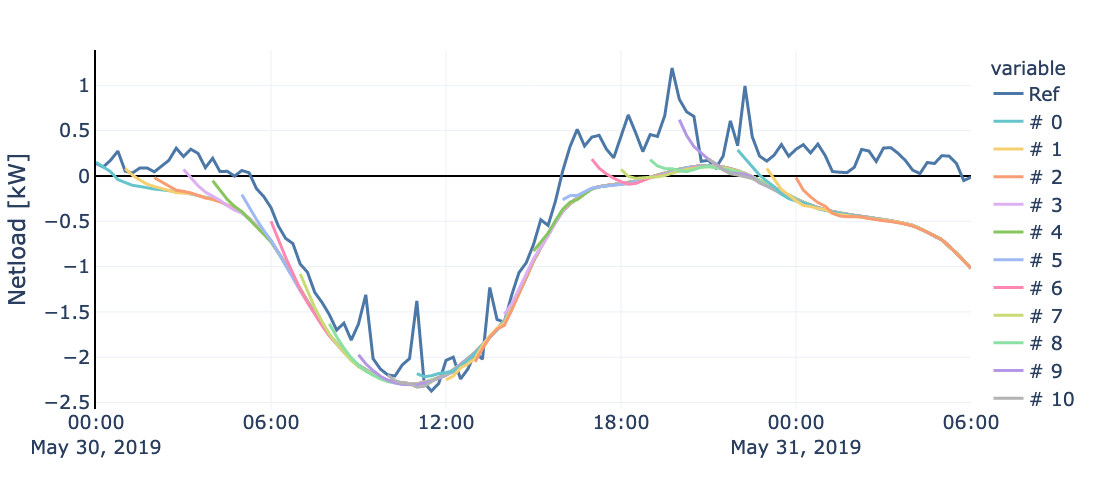

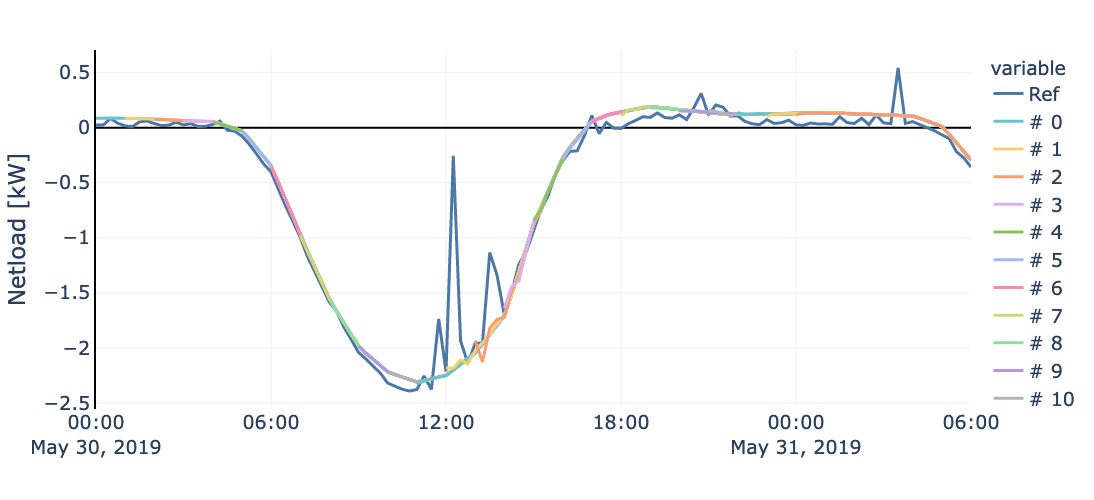

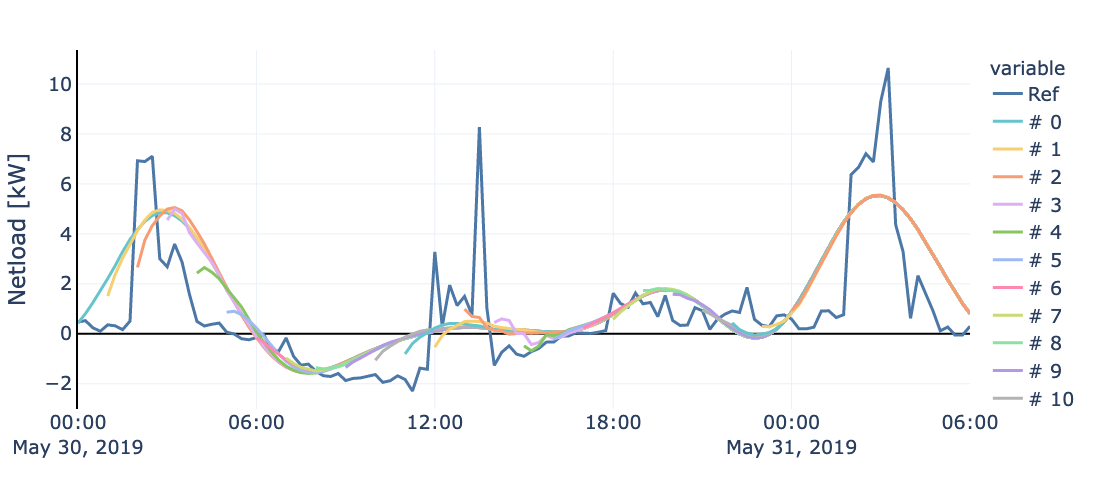

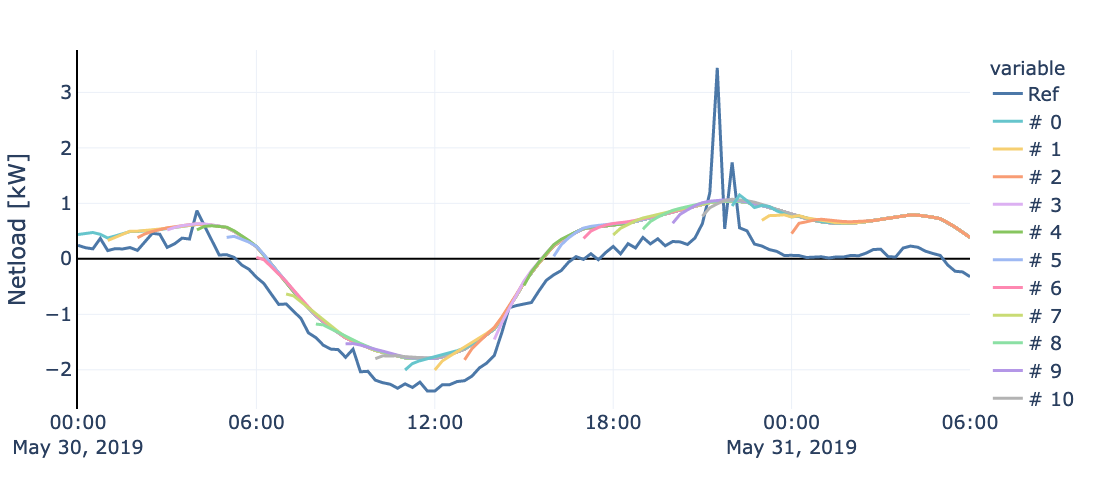

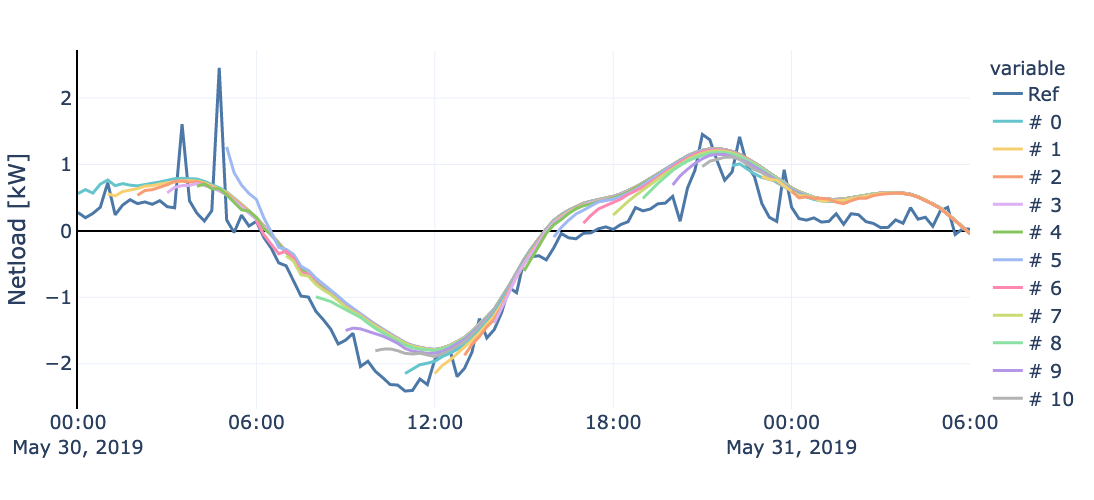

In [69]:
for house_id in house_ids[0:5]:
    graph = individuals.loc[start:end-timedelta(hours=18), [house_id]].copy()
    graph.columns = ["Ref"]

    fig = px.line(graph)
    fig.data[0].update(line_width=3)

    colors = 3 * px.colors.qualitative.Pastel
    for i, _res in enumerate(house_forecasts[house_id]):
        res = _res.copy()
        res.columns = [f"# {i}"]
        trace = px.line(res.loc[start:end-timedelta(hours=18), :]).data[0]
        fig.add_trace(trace)
        fig.data[-1].update(
            line_width=3,
            line_color=colors[i], 
            opacity=1)

    fig.update_layout(
        layout,
        height=500,
        width=1100,
        showlegend=True,
        xaxis_title="",
        yaxis_title="Netload [kW]",
        yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
        xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
        xaxis_tickangle=0)
    fig.show()

# Optimization for all freq

In [77]:
from pyomo.opt import SolverFactory
from pyomo.environ import *
from dataclasses import dataclass
from datetime import timedelta


@dataclass
class OptimizeBatteries:
    grid_buy: float
    grid_fee: float
    battery_aging_cost: float = 0.0
    only_return_schedules: bool = True
    freq: int = 15
    optim_horizon: timedelta = timedelta(days=2)
    solver: str = "glpk"
    solver_path: str = None
    verbose: bool = False
    
    def _solve(self, netloads, members, assets):
        m = ConcreteModel()
        batteries = assets["batt"]

        m.horizon = Set(initialize=list(netloads.keys()), ordered=True)
        m.members = Set(initialize=list(members.keys()), ordered=True)
        m.batteries = Set(initialize=list(batteries.keys()), ordered=True)

        m.community_import = Var(m.horizon, domain=NonNegativeReals)
        m.member_import = Var(m.horizon, m.members, domain=NonNegativeReals)
        m.batteryin = Var(m.horizon, m.batteries, domain=NonNegativeReals)
        m.batteryout = Var(m.horizon, m.batteries, domain=NonNegativeReals)
        m.batteryenergy = Var(m.horizon, m.batteries, domain=NonNegativeReals)

        m.grid_buy = Param(initialize=self.grid_buy)
        m.grid_fee = Param(initialize=self.grid_fee)
        m.battery_aging_cost = Param(initialize=self.battery_aging_cost)
        m.deltat = Param(initialize=self.freq / 60)
        m.last = Param(initialize=m.horizon.last())

        # Battery constraints
        def r_battery_max_powerin(m, t, b):
            return m.batteryin[t, b] <= batteries[b]["max_kw"]

        def r_battery_max_powerout(m, t, b):
            return m.batteryout[t, b] <= batteries[b]["min_kw"]

        def r_battery_energy(m, t, b):
            if t == 0:
                return m.batteryenergy[t, b] == batteries[b]["init_kwh"]
            else:
                return (
                    m.batteryenergy[t, b]
                    == m.batteryenergy[t - 1, b]
                    + m.batteryin[t - 1, b] * m.deltat * batteries[b]["eta"]
                    - m.batteryout[t - 1, b] * m.deltat / batteries[b]["eta"]
                )

        def r_battery_min_energy(m, t, b):
            return (
                m.batteryenergy[t, b]
                >= batteries[b]["max_kwh"] * batteries[b]["offset"]
            )

        def r_battery_max_energy(m, t, b):
            return m.batteryenergy[t, b] <= batteries[b]["max_kwh"] * (
                1 - batteries[b]["offset"]
            )

        def r_battery_end_energy(m, b):
            return m.batteryenergy[m.last, b] >= batteries[b]["end_kwh"]

        def r_battery_end_power_out(m, b):
            return m.batteryout[m.last, b] == 0.0

        def r_battery_end_power_in(m, b):
            return m.batteryin[m.last, b] == 0.0

        # Energy balance
        def r_community_import(m, t):
            return m.community_import[t] >= sum(
                m.batteryin[t, b] - m.batteryout[t, b] for b in m.batteries
            ) + sum(netloads[t][p] for p in m.members)

        def r_member_import(m, t, p):
            return (
                m.member_import[t, p]
                >= sum(
                    m.batteryin[t, b] - m.batteryout[t, b] for b in members[p]["batt"]
                )
                + netloads[t][p]
            )

        m.r1 = Constraint(m.horizon, m.batteries, rule=r_battery_max_powerin)
        m.r2 = Constraint(m.horizon, m.batteries, rule=r_battery_max_powerout)
        m.r3 = Constraint(m.horizon, m.batteries, rule=r_battery_energy)
        m.r4 = Constraint(m.horizon, m.batteries, rule=r_battery_min_energy)
        m.r5 = Constraint(m.horizon, m.batteries, rule=r_battery_max_energy)
        m.r6 = Constraint(m.batteries, rule=r_battery_end_energy)
        m.r7 = Constraint(m.batteries, rule=r_battery_end_power_out)
        m.r8 = Constraint(m.batteries, rule=r_battery_end_power_in)
        m.r9 = Constraint(m.horizon, rule=r_community_import)
        m.r10 = Constraint(m.horizon, m.members, rule=r_member_import)

        def objective_function(m):
            return sum(
                m.grid_buy * m.community_import[i]
                + m.grid_fee
                * (
                    sum(m.member_import[i, p] for p in m.members)
                    - m.community_import[i]
                )
                + m.battery_aging_cost * sum(m.batteryin[i, b] for b in m.batteries)
                for i in m.horizon
            )

        m.objective = Objective(rule=objective_function, sense=minimize)

        with SolverFactory(self.solver, executable=self.solver_path) as opt:
            results = opt.solve(m, tee=False)
            if self.verbose:
                print(results)
        return m
   
    def solve(self, df, member_ids, prod_col, spec):
        netloads = df.copy()
        #for member_id in member_ids:
        #    netloads[member_id] -= df[prod_col]
        #netloads.drop([prod_col], axis=1, inplace=True)
        netloads.index = range(0, len(netloads))
        netloads = netloads.T.to_dict()
        
        members = {member_id:{"batt": [int(i)]} for i, member_id in enumerate(member_ids)}
        
        assets = {}
        assets["batt"] = {i:{
            "min_kw": spec["min_kw"],
            "max_kw": spec["max_kw"],
            "max_kwh": spec["max_kwh"],
            "eta": spec["eta"],
            "offset": spec["offset"],
            "init_kwh": spec["max_kwh"] * spec["offset"],
            "end_kwh": spec["max_kwh"] * spec["offset"]
        } for i, member_id in enumerate(member_ids)}

        model = self._solve(netloads, members, assets)
        return self.postprocess(model, df, member_ids)

    def postprocess(self, model, predictions, member_ids):
        schedules = get_timevar_from_pyomo(model, predictions.index)
        schedules["schedules"] = (
            schedules["batteryin"] - schedules["batteryout"]
        ).copy()

        if self.only_return_schedules:
            schedules = schedules["schedules"]
            schedules.columns = member_ids
        return schedules

def get_timevar_from_pyomo(model, timeindex):
    results = {}
    for var in model.component_objects(Var):
        if var.index_set()._implicit_subsets is None:
            results[var.name] = pd.DataFrame(
                index=[var.name], data=getattr(model, var.name).get_values()
            ).transpose()
            results[var.name].index = timeindex
        else:
            results[var.name] = (
                pd.DataFrame(index=["none"], data=getattr(model, var.name).get_values())
                .transpose()
                .unstack(level=1)
            )
            results[var.name].columns = results[var.name].columns.levels[1]
            results[var.name].index = timeindex
    return results

In [80]:
sub_house_ids = list(house_forecasts.keys())
netload = pd.concat([house_forecasts[house_id][0] for house_id in sub_house_ids], axis=1)
netload.columns = sub_house_ids
netload.head()

,2000989,2001197,2000914,2001123,2000964
2019-05-30 00:00:00,0.152043,0.084521,0.428287,0.438145,0.561345
2019-05-30 00:15:00,0.103187,0.085939,0.806710,0.449836,0.621670
2019-05-30 00:30:00,0.047025,0.088675,1.246334,0.474612,0.568596
2019-05-30 00:45:00,-0.040423,0.087305,1.703164,0.441611,0.703625
2019-05-30 01:00:00,-0.072465,0.084501,2.210373,0.375486,0.766767


In [79]:
battery_size = 5
spec = {"min_kw": battery_size / 2,
        "max_kw": battery_size / 2,
        "max_kwh": battery_size,
        "eta": 0.95,
        "offset": 0.01}

model = OptimizeBatteries(grid_buy=0.1740, grid_fee=0.0371,
                          verbose=True, only_return_schedules=False)
schedule = model.solve(netload, sub_house_ids, "pv_1kw", spec)


Problem: 
- Name: unknown
  Lower bound: 17.6371290954861
  Upper bound: 17.6371290954861
  Number of objectives: 1
  Number of constraints: 3023
  Number of variables: 2038
  Number of nonzeros: 6403
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.062340736389160156
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



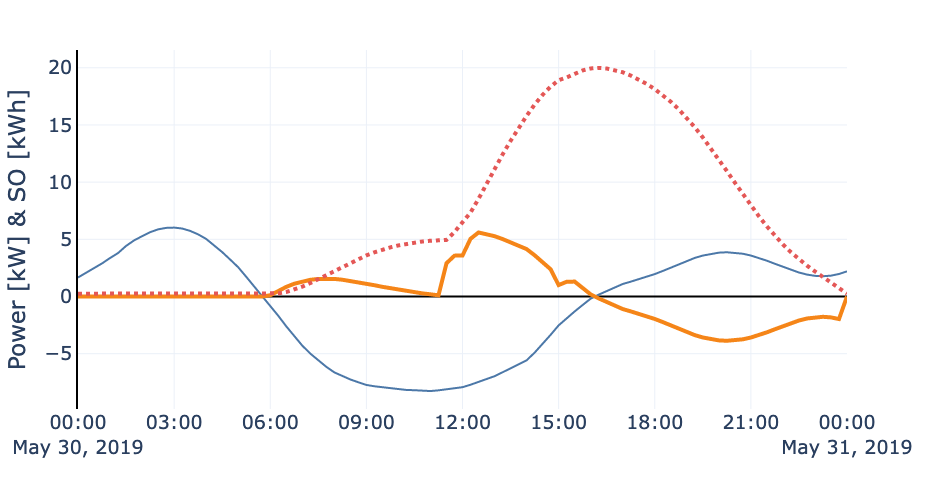

In [85]:
graph = netload.copy()
graph["netload_kw"] = graph[sub_house_ids].sum(axis=1)
graph.drop(sub_house_ids, axis=1, inplace=True)

graph["storage"] = schedule["schedules"].sum(axis=1)
graph["soc"] = schedule["batteryenergy"].sum(axis=1)


fig = px.line(graph, y=["netload_kw", "storage", "soc"])

fig.data[1].update(line_width=4)
fig.data[2].update(line_width=4, line_dash="dot")
fig.update_layout(
    layout,
    height=500,
    width=900,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Power [kW] & SO [kWh]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show()

no error at first cause empty battery... Ok ?

### TODO
- Plot actual multi-optimizations result
- Add perfect
- Calculate costs
- Winter day ?
- More days ?
- Smaller batteries ?

Note: Deadband might be a bad idea since we need more discharging